In [10]:
first_name= "Pouria"
last_name= "Dadkhah"
student_number= "401201381"

Part A)

Advantages of VQ-VAE rather than VAE:

1. **Discrete Latent Space:** One of the primary distinctions is that VQ-VAE has a discrete latent space. In VAEs, the latent space is continuous, which can sometimes lead to suboptimal representations, especially when dealing with structured or categorical data. VQ-VAE, on the other hand, employs vector quantization to create a discrete, codebook-based representation. This can be particularly useful when dealing with data that naturally has categorical or discrete features.

2. **Improved Representations:** The discrete nature of the latent space in VQ-VAE often results in more interpretable and meaningful representations. Each point in the discrete space corresponds to a codeword in the codebook, allowing for a clearer understanding of the learned features.

3. **Stable Training:** VQ-VAE can offer more stable training dynamics compared to VAEs. The discrete latent space introduces a form of regularization, making the model less sensitive to noise and encouraging the learning of more robust representations.

4. **Better Handling of Categorical Data:** VQ-VAE is well-suited for handling categorical data or data with discrete structures. The discrete nature of the latent space is particularly beneficial when dealing with variables that have clear categories or classes.

5. **Enhanced Generation Quality:** The discrete representations learned by VQ-VAE can lead to improved sample generation quality. The model can produce diverse and high-quality samples by selecting different codewords from the codebook during the generation process.

6. **Simpler Decoder Architecture:** The decoder in VQ-VAE is often simpler compared to the decoder in VAE, as it deals with discrete codes rather than continuous variables. This can lead to computational efficiency and ease of implementation.

It's worth noting that the choice between VAE and VQ-VAE depends on the specific characteristics of the data and the task at hand. VQ-VAE is particularly advantageous in scenarios where a discrete and interpretable representation is desired.

in the following parts we're going to implement the desired implementation which is mostly taken from ready implementations of vq-vae models as desired structure ( cnn based ) and we've customized based on mnist dataset and reaching reconstructed results in the ouput.

In [11]:
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms, datasets, utils
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import multiprocessing as mp

In [12]:
num_workers = mp.cpu_count() - 1

Datasets

In [13]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
# Define the train & test dataSets
train_set = datasets.MNIST(root='./data', train=True,
                               download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False,
                              download=True, transform=transform)
num_channels = 1
# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=64, shuffle=True,
                                           num_workers=num_workers, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_set, num_workers=num_workers,
                                          batch_size=16, shuffle=False)


vector_quantizer


In [14]:

# finding the z_e_q given x (by comparing with z_e_x)
class VectorQuantization(Function):
    def forward(ctx, inputs, codeBook):
        with torch.no_grad():
            embedding_size = codeBook.size(1)

            inputs_size = inputs.size()
            inputs_flatten = inputs.view(-1, embedding_size)

            codeBook_sqr = torch.sum(codeBook ** 2, dim=1)
            inputs_sqr = torch.sum(inputs_flatten ** 2, dim=1, keepdim=True)

            distances = torch.addmm(codeBook_sqr + inputs_sqr,
                                    inputs_flatten, codeBook.t(), alpha=-2.0, beta=1.0)

            _, indices_flatten = torch.min(distances, dim=1)
            indices = indices_flatten.view(*inputs_size[:-1])
            ctx.mark_non_differentiable(indices)

            return indices

    def backward(ctx, grad_output):
        raise RuntimeError('Trying to call `.grad()` on graph containing '
                           '`VectorQuantization`. The function `VectorQuantization` '
                           'is not differentiable. Use `VectorQuantizationStraightThrough` '
                           'if you want a straight-through estimator of the gradient.')


# Required to pass gradients received by z_e_q to z_e_x as torch.min function makes the back-propagation gradient
# impossible
class VectorQuantizationStraightThrough(Function):
    def forward(ctx, inputs, codeBook):

        indices = vq(inputs, codeBook)
        indices_flatten = indices.view(-1)
        ctx.save_for_backward(indices_flatten, codeBook)
        ctx.mark_non_differentiable(indices_flatten)
        codes_flatten = torch.index_select(codeBook, dim=0,
                                           index=indices_flatten)
        codes = codes_flatten.view_as(inputs)

        return codes, indices_flatten

    def backward(ctx, grad_output, grad_indices):
        grad_inputs, grad_codeBook = None, None

        if ctx.needs_input_grad[0]:
            grad_inputs = grad_output.clone()
        if ctx.needs_input_grad[1]:
            indices, codeBook = ctx.saved_tensors
            embedding_size = codeBook.size(1)

            grad_output_flatten = (grad_output.contiguous()
                                   .view(-1, embedding_size))

            grad_codeBook = torch.zeros_like(codeBook)
            grad_codeBook.index_add_(0, indices, grad_output_flatten)

        return grad_inputs, grad_codeBook


vq = VectorQuantization.apply
vq_st = VectorQuantizationStraightThrough.apply
__all__ = [vq, vq_st]


modules

In [15]:
# function
def to_scalar(arr):
    if type(arr) == list:
        return [x.item() for x in arr]
    else:
        return arr.item()

# Function to initialize the weights of our network
def weights_init(m):
    className = m.__class__.__name__
    if className.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", className)

# Structure of the embedding layer
class VQEmbedding(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.embedding = nn.Embedding(K, D)
        self.embedding.weight.data.uniform_(-1. / K, 1. / K)

    # z_e_x --> latent code for the input image
    def forward(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        latents = vq(z_e_x_, self.embedding.weight)
        return latents

    # z_e_x --> latent code for the input image
    def straight_through(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()

        z_q_x_, indices = vq_st(z_e_x_, self.embedding.weight.detach())
        z_q_x = z_q_x_.permute(0, 3, 1, 2).contiguous()

        z_q_x_bar_flatten = torch.index_select(self.embedding.weight,
                                               dim=0, index=indices)
        z_q_x_bar_ = z_q_x_bar_flatten.view_as(z_e_x_)
        z_q_x_bar = z_q_x_bar_.permute(0, 3, 1, 2).contiguous()

        return z_q_x, z_q_x_bar

# Structure of the residual block
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


# Architecture of VQ-VAE
class VectorQuantizedVAE(nn.Module):
    def __init__(self, input_dim, dim, K=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 4, 2, 1),
            ResBlock(dim),
            ResBlock(dim),
        )

        self.codeBook = VQEmbedding(K, dim)

        self.decoder = nn.Sequential(
            ResBlock(dim),
            ResBlock(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, input_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def encode(self, x):
        z_e_x = self.encoder(x)
        latents = self.codeBook(z_e_x)
        return latents

    def decode(self, latents):
        z_q_x = self.codeBook.embedding(latents).permute(0, 3, 1, 2)  # (B, C, H, W)
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def forward(self, x):
        z_e_x = self.encoder(x)
        z_q_x_st, z_q_x = self.codeBook.straight_through(z_e_x)
        x_tilde = self.decoder(z_q_x_st)
        return x_tilde, z_e_x, z_q_x


VQ_VAE Model

In [16]:
def train(data_loader, model, optimizer):
    for images, _ in data_loader:

        optimizer.zero_grad()
        x_tilde, z_e_x, z_q_x = model(images)

        loss_recons = F.mse_loss(x_tilde, images)
        loss_vq = F.mse_loss(z_q_x, z_e_x.detach())
        loss_commit = F.mse_loss(z_e_x, z_q_x.detach())

        loss = loss_recons + loss_vq + 0.1 * loss_commit
        loss.backward()
        optimizer.step()

def test(data_loader, model):
    with torch.no_grad():
        loss_recons, loss_vq = 0., 0.
        for images, _ in data_loader:
            x_tilde, z_e_x, z_q_x = model(images)
            loss_recons += F.mse_loss(x_tilde, images)
            loss_vq += F.mse_loss(z_q_x, z_e_x)

        loss_recons /= len(data_loader)
        loss_vq /= len(data_loader)

    print('Validation loss reconstruction: {:f}'.format(loss_recons.item()))
    print('Validation loss quantization: {:f}'.format(loss_vq.item()))

    return loss_recons.item(), loss_vq.item()

def generate_samples(images, model):
    with torch.no_grad():
        x_tilde, _, _ = model(images)
    return x_tilde


Training

In [18]:

#Create a SummaryWriter for logging

writer = SummaryWriter()

fixed_images, _ = next(iter(test_loader))
fixed_grid = make_grid(fixed_images, nrow=8, normalize=True)

writer.add_image('original', fixed_grid, 0)

writer.close()

#hyperparameters

hidden_size=40
k=512
lr=2e-4
model = VectorQuantizedVAE(num_channels, hidden_size, k)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
writer.add_graph(model, fixed_images)

#Begin Training

img_list = []
best_loss = -1.
loss_list = []
for epoch in range(5):
    train(train_loader, model, optimizer)
    loss, _ = test(test_loader, model)

    reconstruction = generate_samples(fixed_images, model)
    grid = make_grid(reconstruction.cpu(), nrow=8, normalize=True)

    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

    loss_list.append(loss)
    img_list.append(grid)

    best_loss = 0.0
    if loss < best_loss:
        best_loss = loss
        best_model = model.state_dict()
        # Save the best model to a file
        torch.save(best_model, 'best_VQ_vae_model.pth')
        print("Best model saved as 'best_VQ_vae_model.pth'")


Validation loss reconstruction: 0.080543
Validation loss quantization: 4.344129
Epoch 1, Loss: 0.0805
Validation loss reconstruction: 0.069912
Validation loss quantization: 4.687723
Epoch 2, Loss: 0.0699
Validation loss reconstruction: 0.064294
Validation loss quantization: 3.829253
Epoch 3, Loss: 0.0643
Validation loss reconstruction: 0.058878
Validation loss quantization: 3.061469
Epoch 4, Loss: 0.0589
Validation loss reconstruction: 0.055089
Validation loss quantization: 2.349454
Epoch 5, Loss: 0.0551


Results

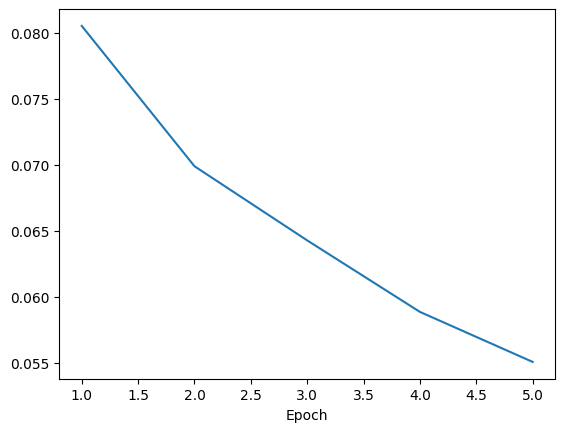

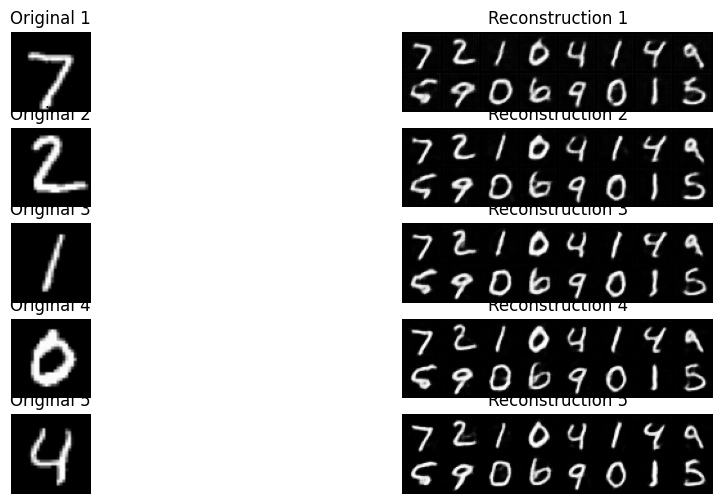

In [19]:
plt.plot(range(1, epoch + 2), loss_list, label=' Loss')
plt.xlabel('Epoch')

# Convert them to NumPy arrays before plotting
img_list_np = [img.numpy() for img in img_list]

# Plot each original and reconstructed image pair
plt.figure(figsize=(12, 6))
for i, (original, reconstruction) in enumerate(zip(fixed_images, img_list_np)):
    plt.subplot(len(img_list), 2, 2 * i + 1)
    plt.imshow(np.transpose(make_grid(original, nrow=8, normalize=True).numpy(), (1, 2, 0)))
    plt.title(f'Original {i + 1}')
    plt.axis('off')

    plt.subplot(len(img_list), 2, 2 * i + 2)
    plt.imshow(np.transpose(reconstruction, (1, 2, 0)))
    plt.title(f'Reconstruction {i + 1}')
    plt.axis('off')

plt.show()